# 作业1 实现多入单出的单层神经网络，实现北京房价预测

特征值 x1：地理位置, 特征值 x2: 居住面积，标签值 y：房价
输出：预测值 z：房价

### 思路整理
- 1，构建神经网络
    
    - 1.1 定义一个一层神经网络
    
        - 只有输入层和输出层；
        - 输出层只有一个神经元；
        - 神经元有一个线性输出（无激活函数）。
    
    - 1.2 正向计算
    - 1.3 误差反向传播
- 2，装载和预处理数据    
    - 数据处理：归一化（包括样本、标签）
- 3，训练

- 4，预测

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pathlib import Path
from matplotlib.colors import LogNorm

In [172]:
class NeuralNet(object):
    def __init__(self, params):
        self.params = params
        self.W = np.zeros((self.params.input_size, self.params.output_size))
        self.B = np.zeros((1, self.params.output_size))

    def forward(self, batch_x):
        Z = np.dot(batch_x, self.W) + self.B
        return Z

    def backward(self, batch_x, batch_y, batch_z):
        m = batch_x.shape[0]
        dZ = batch_z - batch_y
        dB = dZ.sum(axis=0, keepdims=True)/m
        dW = np.dot(batch_x.T, dZ)/m
        return dW, dB

    def update(self, dW, dB):
        self.W = self.W - self.params.eta * dW
        self.B = self.B - self.params.eta * dB

    def checkLoss(self, dataReader):
        X,Y = dataReader.GetWholeTrainSamples()
        m = X.shape[0]
        Z = self.forward(X)
        LOSS = (Z - Y)**2
        loss = LOSS.sum()/m/2
        return loss
    
    def inference(self, x):
        return self.forward(x)
#end class NeuralNet

In [173]:
class SimpleDataReader(object):
    def __init__(self):
        self.train_file_name = "data/ch05.npz"
        self.num_train = 0
        self.XTrain = None
        self.YTrain = None
        self.XRaw = None
        self.YRaw = None

    # read data from file
    def ReadData(self):
        train_file = Path(self.train_file_name)
        if train_file.exists():
            data = np.load(self.train_file_name)
            self.XRaw = data["data"]
            self.YRaw = data["label"]
            self.num_train = self.XRaw.shape[0]
            self.XTrain = self.XRaw
            self.YTrain = self.YRaw
        else:
            raise Exception("Cannot find train file!!!")
        #end if

    def NormalizeX(self):
        X_new = np.zeros(self.XRaw.shape)
        num_feature = self.XRaw.shape[1]
        self.X_norm = np.zeros((num_feature,2))
        for i in range(num_feature):            
            col_i = self.XRaw[:,i]
            max_value = np.max(col_i)
            min_value = np.min(col_i)            
            self.X_norm[i,0] = min_value             
            self.X_norm[i,1] = max_value - min_value 
            new_col = (col_i - self.X_norm[i,0])/(self.X_norm[i,1])
            X_new[:,i] = new_col
        #end for
        self.XTrain = X_new

    def NormalizePredicateData(self, X_raw):
        X_new = np.zeros(X_raw.shape)
        n = X_raw.shape[1]
        for i in range(n):
            col_i = X_raw[:,i]
            X_new[:,i] = (col_i - self.X_norm[i,0]) / self.X_norm[i,1]
        return X_new

    def NormalizeY(self):
        self.Y_norm = np.zeros((1,2))
        max_value = np.max(self.YRaw)
        min_value = np.min(self.YRaw)
        self.Y_norm[0, 0] = min_value 
        self.Y_norm[0, 1] = max_value - min_value 
        y_new = (self.YRaw - min_value) / self.Y_norm[0, 1]
        self.YTrain = y_new

    # get batch training data
    def GetSingleTrainSample(self, iteration):
        x = self.XTrain[iteration]
        y = self.YTrain[iteration]
        return x, y

    # get batch training data
    def GetBatchTrainSamples(self, batch_size, iteration):
        start = iteration * batch_size
        end = start + batch_size
        batch_X = self.XTrain[start:end,:]
        batch_Y = self.YTrain[start:end,:]
        return batch_X, batch_Y

    def GetWholeTrainSamples(self):
        return self.XTrain, self.YTrain

    def Shuffle(self):
        seed = np.random.randint(0,100)
        np.random.seed(seed)
        XP = np.random.permutation(self.XTrain)
        np.random.seed(seed)
        YP = np.random.permutation(self.YTrain)
        self.XTrain = XP
        self.YTrain = YP
#end class SimpleDataReader

In [174]:
class HyperParameters(object):
    def __init__(self, input_size, output_size, eta=0.1, max_epoch=1000, batch_size=5, eps=0.1):
        self.input_size = input_size
        self.output_size = output_size
        self.eta = eta
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.eps = eps

    def toString(self):
        title = str.format("bz:{0},eta:{1}", self.batch_size, self.eta)
        return title
#end class HyperParameters 

In [175]:
class TrainingHistory(object):
    def __init__(self):
        self.iteration = []
        self.loss_history = []
        self.w_history = []
        self.b_history = []

    def AddLossHistory(self, iteration, loss, w, b):
        self.iteration.append(iteration)
        self.loss_history.append(loss)
        self.w_history.append(w)
        self.b_history.append(b)

    def ShowLossHistory(self, params, xmin=None, xmax=None, ymin=None, ymax=None):
        plt.plot(self.iteration, self.loss_history)
        title = params.toString()
        plt.title(title)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        if xmin != None and ymin != None:
            plt.axis([xmin, xmax, ymin, ymax])
        plt.show()
        return title

    def GetLast(self):
        count = len(self.loss_history)
        return self.loss_history[count-1], self.w_history[count-1], self.b_history[count-1]
# end class

In [178]:
def train01(net, dataReader, checkpoint=0.1):
    loss_history = TrainingHistory()
    loss = 10
    if net.params.batch_size == -1:
        net.params.batch_size = dataReader.num_train
    max_iteration = math.ceil(dataReader.num_train / net.params.batch_size)
    print("max_iteration * checkpoint:",max_iteration * checkpoint)
    checkpoint_iteration = (int)(max_iteration * checkpoint)

    for epoch in range(net.params.max_epoch):
        print("epoch=%d" %epoch)
        dataReader.Shuffle()
        for iteration in range(max_iteration):
            batch_x, batch_y = dataReader.GetBatchTrainSamples(net.params.batch_size, iteration)
            batch_z = net.forward(batch_x)
            dW, dB = net.backward(batch_x, batch_y, batch_z)
            net.update(dW, dB)

            total_iteration = epoch * max_iteration + iteration
            if (total_iteration+1) % checkpoint_iteration == 0:
                loss = net.checkLoss(dataReader)
                print(epoch, iteration, loss, net.W, net.B)
                loss_history.AddLossHistory(epoch*max_iteration+iteration, loss,net.W,net.B)
                if loss < net.params.eps:
                    break
                #end if
            #end if
        # end for
        if loss < net.params.eps:
            break
    # end for
    loss_history.ShowLossHistory(net.params)
    print("W=", net.W)
    print("B=", net.B)

max_iteration * checkpoint: 10.0
epoch=0
0 9 0.11083542474827292 [[0.02765121]
 [0.03354573]] [[0.04938598]]
0 19 0.08563569577987187 [[0.0469001 ]
 [0.06133011]] [[0.08898516]]
0 29 0.06795892699220732 [[0.0613631 ]
 [0.08468883]] [[0.12182633]]
0 39 0.05618910558996349 [[0.07083641]
 [0.10285165]] [[0.14781611]]
0 49 0.0470190745769863 [[0.08091228]
 [0.11989336]] [[0.16979801]]
0 59 0.039233743038755306 [[0.09060178]
 [0.13650703]] [[0.1917793]]
0 69 0.03416220890662242 [[0.09797873]
 [0.14949566]] [[0.20815443]]
0 79 0.030318958203282995 [[0.10315018]
 [0.16228672]] [[0.22162101]]
0 89 0.028488987518122007 [[0.1037565 ]
 [0.17059863]] [[0.22807786]]
0 99 0.025484231425524854 [[0.10847842]
 [0.1829343 ]] [[0.24147571]]
epoch=1
1 9 0.023659194192660046 [[0.11065399]
 [0.19277116]] [[0.24999119]]
1 19 0.02200376046086904 [[0.11379188]
 [0.20249209]] [[0.25911487]]
1 29 0.02092794976185148 [[0.1137135 ]
 [0.21074919]] [[0.26502892]]
1 39 0.01986002393560459 [[0.11485041]
 [0.21991961]]

12 39 0.004283575631001902 [[-0.02893592]
 [ 0.56835821]] [[0.22484747]]
12 49 0.004237397091022356 [[-0.02987978]
 [ 0.57026094]] [[0.22415492]]
12 59 0.004192870779134331 [[-0.03040403]
 [ 0.57232272]] [[0.22370845]]
12 69 0.00415201335519356 [[-0.03082173]
 [ 0.57424432]] [[0.22322711]]
12 79 0.004109435818930803 [[-0.03215135]
 [ 0.57586371]] [[0.22255911]]
12 89 0.00406495499704074 [[-0.03236472]
 [ 0.57850112]] [[0.2232923]]
12 99 0.004030722571832701 [[-0.03319623]
 [ 0.5797682 ]] [[0.22234557]]
epoch=13
13 9 0.003987816174119018 [[-0.03407761]
 [ 0.58184828]] [[0.22229659]]
13 19 0.003954288890392363 [[-0.034597 ]
 [ 0.5835511]] [[0.22217354]]
13 29 0.003910845114636471 [[-0.03536467]
 [ 0.58546273]] [[0.22131391]]
13 39 0.0038711446019227447 [[-0.03649134]
 [ 0.58678576]] [[0.21970566]]
13 49 0.0038360541796620107 [[-0.03672781]
 [ 0.58883886]] [[0.21993685]]
13 59 0.0038043430638619842 [[-0.0371561 ]
 [ 0.59021634]] [[0.21893214]]
13 69 0.003771670385176569 [[-0.03794111]
 [ 

 [ 0.71410724]] [[0.17604821]]
24 79 0.0019635344833191385 [[-0.08006655]
 [ 0.71512761]] [[0.17589322]]
24 89 0.0019584221647090403 [[-0.08020061]
 [ 0.71600766]] [[0.17637798]]
24 99 0.0019529355520280548 [[-0.0804265 ]
 [ 0.71672451]] [[0.17629103]]
epoch=25
25 9 0.0019487542240360786 [[-0.08136185]
 [ 0.71663453]] [[0.17454226]]
25 19 0.001943165442623663 [[-0.08146536]
 [ 0.71734379]] [[0.17445639]]
25 29 0.0019359872637990238 [[-0.08108742]
 [ 0.71874407]] [[0.17549499]]
25 39 0.0019297826794505294 [[-0.0809584 ]
 [ 0.71989371]] [[0.17569904]]
25 49 0.00192487159649717 [[-0.08093335]
 [ 0.72071963]] [[0.17566567]]
25 59 0.0019203155087928678 [[-0.08098175]
 [ 0.72167248]] [[0.17584748]]
25 69 0.0019151558953805635 [[-0.08118771]
 [ 0.72209289]] [[0.17534891]]
25 79 0.0019120593503102413 [[-0.08106141]
 [ 0.72252775]] [[0.17511806]]
25 89 0.001907454929980199 [[-0.08146624]
 [ 0.72260579]] [[0.17432367]]
25 99 0.0019001277897249843 [[-0.08235688]
 [ 0.72293923]] [[0.17293023]]
epo

37 19 0.0016355117962130756 [[-0.0893342 ]
 [ 0.77102888]] [[0.15222024]]
37 29 0.0016346172039553594 [[-0.08929315]
 [ 0.77145718]] [[0.1523654]]
37 39 0.0016336490728692467 [[-0.08909777]
 [ 0.77175395]] [[0.15219738]]
37 49 0.0016331103846344446 [[-0.08892306]
 [ 0.77220172]] [[0.15239634]]
37 59 0.00163207346979111 [[-0.08890865]
 [ 0.77255287]] [[0.15226939]]
37 69 0.001631216498978982 [[-0.08966017]
 [ 0.77214153]] [[0.15103818]]
37 79 0.001630046897179549 [[-0.0892621 ]
 [ 0.77272189]] [[0.15149822]]
37 89 0.0016290939466933555 [[-0.08926437]
 [ 0.77313185]] [[0.15152896]]
37 99 0.0016281232920229384 [[-0.08944436]
 [ 0.7732365 ]] [[0.15106789]]
epoch=38
38 9 0.0016275242860082503 [[-0.08936439]
 [ 0.77324112]] [[0.15045095]]
38 19 0.0016269240188560366 [[-0.08917681]
 [ 0.77347261]] [[0.1505493]]
38 29 0.0016256281123193312 [[-0.08918924]
 [ 0.77413556]] [[0.150853]]
38 39 0.0016255308745271456 [[-0.08934899]
 [ 0.77381371]] [[0.14982492]]
38 49 0.0016256592929759178 [[-0.08978

49 29 0.0015804854913882556 [[-0.08873243]
 [ 0.79339015]] [[0.14048002]]
49 39 0.0015809664991736439 [[-0.08848345]
 [ 0.79409967]] [[0.14110726]]
49 49 0.001580418306855567 [[-0.08827447]
 [ 0.79418144]] [[0.14079512]]
49 59 0.0015802717243543745 [[-0.08808325]
 [ 0.7941962 ]] [[0.14067685]]
49 69 0.001579497721027522 [[-0.08848605]
 [ 0.79388404]] [[0.13993656]]
49 79 0.0015797388667979195 [[-0.08830708]
 [ 0.79387226]] [[0.14020087]]
49 89 0.00157948523177639 [[-0.0883076 ]
 [ 0.79371407]] [[0.13967912]]
49 99 0.0015793810957086608 [[-0.08829655]
 [ 0.7937453 ]] [[0.13953353]]
epoch=50
50 9 0.0015793299796639357 [[-0.08805136]
 [ 0.79395883]] [[0.13987789]]
50 19 0.0015804134185119143 [[-0.08741087]
 [ 0.79449998]] [[0.14061567]]
50 29 0.0015802182195250051 [[-0.08753633]
 [ 0.79461124]] [[0.14057845]]
50 39 0.0015816901216440795 [[-0.08698798]
 [ 0.79517242]] [[0.14093906]]
50 49 0.0015799190081964287 [[-0.08721102]
 [ 0.794986  ]] [[0.1403793]]
50 59 0.0015795284343466318 [[-0.08

61 9 0.0015695135210849966 [[-0.0860906 ]
 [ 0.80220349]] [[0.13421613]]
61 19 0.0015694954796237365 [[-0.08620861]
 [ 0.80242348]] [[0.1343652]]
61 29 0.0015695565189177568 [[-0.08640558]
 [ 0.80225555]] [[0.13383178]]
61 39 0.0015695064419023444 [[-0.08613321]
 [ 0.80217248]] [[0.13375484]]
61 49 0.0015692335911081 [[-0.08587972]
 [ 0.80275774]] [[0.13415602]]
61 59 0.0015691205480688926 [[-0.08595112]
 [ 0.80288088]] [[0.13403142]]
61 69 0.0015695900159984223 [[-0.08628798]
 [ 0.80237825]] [[0.13329733]]
61 79 0.0015695622773030894 [[-0.08560874]
 [ 0.80303897]] [[0.134496]]
61 89 0.0015704747003527449 [[-0.08536176]
 [ 0.80331347]] [[0.13494471]]
61 99 0.0015693525180631074 [[-0.08567504]
 [ 0.80286239]] [[0.13431297]]
epoch=62
62 9 0.0015700354307064711 [[-0.08541155]
 [ 0.80313781]] [[0.13475101]]
62 19 0.0015698118675508076 [[-0.08519648]
 [ 0.80295737]] [[0.13456158]]
62 29 0.0015691745951875596 [[-0.0858723 ]
 [ 0.80251245]] [[0.13366818]]
62 39 0.001569089505282131 [[-0.08572

80 89 0.001566398361707019 [[-0.08336285]
 [ 0.80800373]] [[0.13014023]]
80 99 0.0015663589583493288 [[-0.08329756]
 [ 0.80786622]] [[0.13004682]]
epoch=81
81 9 0.0015666045417578253 [[-0.08366305]
 [ 0.80752616]] [[0.1294123]]
81 19 0.0015664866807696134 [[-0.08367794]
 [ 0.80756681]] [[0.12962059]]
81 29 0.0015663797438465097 [[-0.08336669]
 [ 0.80748072]] [[0.12990851]]
81 39 0.0015668585545060522 [[-0.08369547]
 [ 0.80723804]] [[0.12932485]]
81 49 0.0015667913480003036 [[-0.08279773]
 [ 0.80770177]] [[0.13052828]]
81 59 0.0015665366724393688 [[-0.08308611]
 [ 0.80763925]] [[0.13035468]]
81 69 0.0015663870087028672 [[-0.08323666]
 [ 0.80756592]] [[0.13008803]]
81 79 0.0015665825506555534 [[-0.08316909]
 [ 0.80816219]] [[0.1303155]]
81 89 0.001566281875520909 [[-0.08327412]
 [ 0.80797605]] [[0.12978647]]
81 99 0.001566332034657287 [[-0.08319445]
 [ 0.80802993]] [[0.12995687]]
epoch=82
82 9 0.001567232991021594 [[-0.08263945]
 [ 0.80869869]] [[0.13044444]]
82 19 0.0015662379855874203 

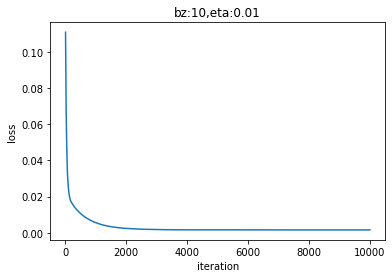

W= [[-0.08227098]
 [ 0.80945963]]
B= [[0.12862736]]
z= [[0.66925408]]
Z_real= [[511.32275454]]


In [179]:
reader = SimpleDataReader()
reader.ReadData()
reader.NormalizeX()
reader.NormalizeY()
# net
params = HyperParameters(2, 1, eta=0.01, max_epoch=100, batch_size=10, eps=1e-5)
net = NeuralNet(params)
train01(net,reader, checkpoint=0.1)
#推测
x1 = 20
x2 = 100
x = np.array([x1,x2]).reshape(1,2)
x_new = reader.NormalizePredicateData(x)
z = net.inference(x_new)
print("z=", z)
Z_real = z * reader.Y_norm[0,1] + reader.Y_norm[0,0]
print("Z_real=", Z_real)